# Определение перспективного тарифа для телеком-компании


**Описание проекта**

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Изучение данных из файлов

### Загрузка файлов

In [1]:
import pandas as pd
from datetime import datetime as dt
import numpy as np
from scipy import stats as st

import warnings

warnings.filterwarnings("ignore")

calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv', index_col=0)
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

In [2]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [3]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


- У нас есть 5 файлов, из которых мы будем получать всю необходимую информацию. 

Первый файл `calls` - 4 столбца, 202.607 строк, пропуски не наблюдаю. Сразу видим, что колонку с датой надо будет перевести в другой тип. 


In [4]:
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [5]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


Второй - `internet`. Тут у нас 5 столбцов, 149.396 строк (что гораздо меньше первого файла). Надо будет отже поработать с типом данных в этом датасете. Кстати, общий столбец - user_id. Возможно, именно по нему придеться объеденить файлы. 

In [6]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [7]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Третий - `messages`. 3 столбца, 123.036 строк. Еще меньше. Зато до сих пор без пропусков. Общий все тот же столбец с id.

In [8]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [9]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


Четвертый - `tariffs`. 8 столбцов и 2 строки. У нас всего два тарифа, поэтому очевидно. 

In [10]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [11]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


И, наконец, пятый - `users`. Здесь у нас 8 столбцов, 500 строк. Скорее всего это та самая выборка по 500 пользователям. 

### Вывод

Методом `.info()` мы проверили все датасеты и узнали информацию. Сейчас предстоит немного привести в порядок данные и объединить таблицы для дальнейшей работы. 

Названия колонок: 

**Таблица users (информация о пользователях):**
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

**Таблица calls (информация о звонках):**
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

**Таблица messages (информация о сообщениях):**
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

**Таблица internet (информация об интернет-сессиях):**
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

**Таблица tariffs (информация о тарифах):**
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

## Предобработка данных

### Проверка пропусков

In [12]:
#на всякий случай проверим пропуски во всех датасетах

users.isna().sum()

user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

Пропуск только в столбце даты прекращения пользования тарифом. Указано, что пропуск является основанием полагать, что на момент выгрузки тариф все еще действует) 

In [13]:
messages.isna().sum()

id              0
message_date    0
user_id         0
dtype: int64

In [14]:
internet.isna().sum()

id              0
mb_used         0
session_date    0
user_id         0
dtype: int64

In [15]:
calls.isna().sum()

id           0
call_date    0
duration     0
user_id      0
dtype: int64

In [16]:
tariffs.isna().sum()

messages_included        0
mb_per_month_included    0
minutes_included         0
rub_monthly_fee          0
rub_per_gb               0
rub_per_message          0
rub_per_minute           0
tariff_name              0
dtype: int64

Как здорово, пропуски отсутствуют) Едем дальше!

### Изменение типов данных

In [17]:
#поменяем везде дату на тип данных даты

calls['call_date'] = pd.to_datetime(calls['call_date'], format = '%Y-%m-%d')
calls.info()
#с помощью метода info проверяем, что Dtype изменился на нужный

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


In [18]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format = '%Y-%m-%d')
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            149396 non-null  object        
 1   mb_used       149396 non-null  float64       
 2   session_date  149396 non-null  datetime64[ns]
 3   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 5.7+ MB


In [19]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format = '%Y-%m-%d')
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


In [20]:
users['churn_date'] = pd.to_datetime(users['churn_date'], format = '%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format = '%Y-%m-%d')
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


### Добавление столбца month

In [21]:
messages['month'] = messages['message_date'].dt.month
messages.pop('message_date')
messages.head()

,id,user_id,month
0,1000_0,1000,6
1,1000_1,1000,10
2,1000_2,1000,8
3,1000_3,1000,6
4,1000_4,1000,12


In [22]:
internet['month'] = internet['session_date'].dt.month
internet.pop('session_date')
internet.head()

,id,mb_used,user_id,month
0,1000_0,112.95,1000,11
1,1000_1,1052.81,1000,9
2,1000_2,1197.26,1000,6
3,1000_3,550.27,1000,8
4,1000_4,302.56,1000,9


In [23]:
calls['month'] = calls['call_date'].dt.month
calls.pop('call_date')
calls.head()

,id,duration,user_id,month
0,1000_0,0.00,1000,7
1,1000_1,0.00,1000,8
2,1000_2,2.85,1000,6
3,1000_3,13.80,1000,9
4,1000_4,5.18,1000,12


Теперь у нас есть номер месяца, в который совершали действия

### Округление данных

In [24]:
#согласно условиям, округление в компании происходит в большую сторону.
internet.head()

,id,mb_used,user_id,month
0,1000_0,112.95,1000,11
1,1000_1,1052.81,1000,9
2,1000_2,1197.26,1000,6
3,1000_3,550.27,1000,8
4,1000_4,302.56,1000,9


In [25]:
#столбец mb_used переведем в гигабайты и округлим

internet = internet.rename(columns={'mb_used':'gb_used'})
internet['gb_used'] = internet['gb_used']/1024
#internet['gb_used'] = np.ceil(internet['gb_used'])
#internet['gb_used'] = internet['gb_used'].astype(int)
internet.head()

,id,gb_used,user_id,month
0,1000_0,0.110303,1000,11
1,1000_1,1.028135,1000,9
2,1000_2,1.169199,1000,6
3,1000_3,0.537373,1000,8
4,1000_4,0.295469,1000,9


In [26]:
#повторим со звонками
calls.head()

,id,duration,user_id,month
0,1000_0,0.00,1000,7
1,1000_1,0.00,1000,8
2,1000_2,2.85,1000,6
3,1000_3,13.80,1000,9
4,1000_4,5.18,1000,12


In [27]:
calls['duration'] = np.ceil(calls['duration'])
calls['duration'] = calls['duration'].astype(int)
calls.head()

,id,duration,user_id,month
0,1000_0,0,1000,7
1,1000_1,0,1000,8
2,1000_2,3,1000,6
3,1000_3,14,1000,9
4,1000_4,6,1000,12


### Добавление расчетов

**Количество сделанных звонков и израсходованных минут разговора по месяцам**

In [28]:
#количество минут в месяц
calls_min_sum = calls.pivot_table(index = ['user_id', 'month'],
                    
                     values = 'duration',
                     aggfunc = 'sum')
calls_min_sum = calls_min_sum.reset_index()
calls_min_sum.head()

,user_id,month,duration
0,1000,5,159
1,1000,6,172
2,1000,7,340
3,1000,8,408
4,1000,9,466


In [29]:
#количество звонков в месяц
calls_count = calls.pivot_table(index = ['user_id', 'month'],
                     
                     values = 'duration',
                     aggfunc = 'count')
calls_count = calls_count.reset_index()
calls_count.head()

,user_id,month,duration
0,1000,5,22
1,1000,6,43
2,1000,7,47
3,1000,8,52
4,1000,9,58


**Количество отправленных сообщений по месяцам**

In [30]:
messages_sum = messages.pivot_table(index = ['user_id', 'month'],
                     
                     values = 'id',
                     aggfunc = 'count')
messages_sum = messages_sum.reset_index()
messages_sum.head()

,user_id,month,id
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


**Объем израсходованного интернет-трафика по месяцам**

In [31]:
internet_sum = internet.pivot_table(index = ['user_id','month'],
                      
                     values = 'gb_used',
                     aggfunc = 'sum')

internet_sum = internet_sum.reset_index()
internet_sum.head()

,user_id,month,gb_used
0,1000,5,2.200674
1,1000,6,22.689229
2,1000,7,13.675430
3,1000,8,13.726494
4,1000,9,14.227451


In [32]:
tariff = users[['user_id', 'tariff']]
tariff.head()

,user_id,tariff
0,1000,ultra
1,1001,smart
2,1002,smart
3,1003,ultra
4,1004,ultra


In [33]:
#создаем общую таблицу
data = users.merge(internet_sum, on='user_id', how='outer')
data = data.merge(calls_min_sum, on=['user_id', 'month'], how='outer')
data = data.merge(messages_sum, on=['user_id', 'month'], how='outer')

data = data.rename(columns={'duration':'minut'})
data = data.rename(columns={'id':'message'})
data.head(10)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,gb_used,minut,message
0,1000,52.0,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5.0,2.200674,159.0,22.0
1,1000,52.0,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.0,22.689229,172.0,60.0
2,1000,52.0,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7.0,13.675430,340.0,75.0
3,1000,52.0,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0,13.726494,408.0,81.0
4,1000,52.0,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9.0,14.227451,466.0,57.0
5,1000,52.0,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,10.0,14.357900,350.0,73.0
6,1000,52.0,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,11.0,14.410615,338.0,58.0
7,1000,52.0,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,12.0,9.587510,333.0,70.0
8,1001,41.0,NaT,Москва,Иван,Ежов,2018-11-01,smart,11.0,17.997402,430.0,NaN
9,1001,41.0,NaT,Москва,Иван,Ежов,2018-11-01,smart,12.0,13.707676,414.0,NaN


In [34]:
len(data['user_id'].unique())

500

Число уникальных пользователей 497. Выборка достаточна для проведения анализа. Из 500 трое куда-то потерялись, я думаю это пустые клиенты, которые не совершали звонков и тд. 

**Помесячная выручка с каждого пользователя**

(вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану)

In [35]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Напоминалка о значениях столбцов:

- ariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [36]:
#переведем мегабайты в гигабайты
tariffs['mb_per_month_included'] = tariffs['mb_per_month_included']/1024
tariffs['mb_per_month_included'] = tariffs['mb_per_month_included'].astype(int)
tariffs


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15,500,550,200,3,3,smart
1,1000,30,3000,1950,150,1,1,ultra


In [37]:
#округлим теперь в нашей таблице Гб до целого числа
data['gb_used'] = np.ceil(data['gb_used'])

data.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,gb_used,minut,message
0,1000,52.0,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5.0,3.0,159.0,22.0
1,1000,52.0,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.0,23.0,172.0,60.0
2,1000,52.0,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7.0,14.0,340.0,75.0
3,1000,52.0,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0,14.0,408.0,81.0
4,1000,52.0,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9.0,15.0,466.0,57.0


In [38]:
#создаем функцию для подсчета выручки с каждого пользователя за оплату тарифа
def t_pay (row):
    tariff = row['tariff']
    if tariff == 'smart':
        return 550
    return 1950

data['tariff_pay'] = data.apply(t_pay, axis=1)
data.head(10)
        

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,gb_used,minut,message,tariff_pay
0,1000,52.0,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5.0,3.0,159.0,22.0,1950
1,1000,52.0,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.0,23.0,172.0,60.0,1950
2,1000,52.0,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7.0,14.0,340.0,75.0,1950
3,1000,52.0,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0,14.0,408.0,81.0,1950
4,1000,52.0,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9.0,15.0,466.0,57.0,1950
5,1000,52.0,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,10.0,15.0,350.0,73.0,1950
6,1000,52.0,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,11.0,15.0,338.0,58.0,1950
7,1000,52.0,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,12.0,10.0,333.0,70.0,1950
8,1001,41.0,NaT,Москва,Иван,Ежов,2018-11-01,smart,11.0,18.0,430.0,NaN,550
9,1001,41.0,NaT,Москва,Иван,Ежов,2018-11-01,smart,12.0,14.0,414.0,NaN,550


Теперь у нас появилась колонка с сумой оплаты пользователем за тариф в каждый месяц, в зависимости от тарифа

In [39]:
#создаем функцию для подсчета платежей сверх лимита
def pay (row):
    minut = row['minut']
    gb = row['gb_used']
    sms = row['message']
    tariff = row['tariff']
    summa = 0
    if tariff == 'smart':
        if minut > 500:
            summa+=(minut-500)*3
        if gb > 15:
            summa+=(gb-15)*200
        if sms > 50:
            summa+=(sms-50)*3
        return summa
    
    if tariff == 'ultra':
        if minut > 3000:
            summa+=(minut-3000)*1
        if gb > 30:
            summa+=(gb-30)*150
        if sms > 1000:
            summa+=(sms-1000)*1
        return summa
        
data['dop_pay'] = data.apply(pay, axis=1)
data.head(10)
        

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,gb_used,minut,message,tariff_pay,dop_pay
0,1000,52.0,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5.0,3.0,159.0,22.0,1950,0.0
1,1000,52.0,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.0,23.0,172.0,60.0,1950,0.0
2,1000,52.0,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7.0,14.0,340.0,75.0,1950,0.0
3,1000,52.0,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0,14.0,408.0,81.0,1950,0.0
4,1000,52.0,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9.0,15.0,466.0,57.0,1950,0.0
5,1000,52.0,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,10.0,15.0,350.0,73.0,1950,0.0
6,1000,52.0,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,11.0,15.0,338.0,58.0,1950,0.0
7,1000,52.0,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,12.0,10.0,333.0,70.0,1950,0.0
8,1001,41.0,NaT,Москва,Иван,Ежов,2018-11-01,smart,11.0,18.0,430.0,NaN,550,600.0
9,1001,41.0,NaT,Москва,Иван,Ежов,2018-11-01,smart,12.0,14.0,414.0,NaN,550,0.0


In [40]:
data['profit'] = data['tariff_pay'] + data['dop_pay']
data.head(10)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,gb_used,minut,message,tariff_pay,dop_pay,profit
0,1000,52.0,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5.0,3.0,159.0,22.0,1950,0.0,1950.0
1,1000,52.0,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.0,23.0,172.0,60.0,1950,0.0,1950.0
2,1000,52.0,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7.0,14.0,340.0,75.0,1950,0.0,1950.0
3,1000,52.0,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0,14.0,408.0,81.0,1950,0.0,1950.0
4,1000,52.0,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9.0,15.0,466.0,57.0,1950,0.0,1950.0
5,1000,52.0,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,10.0,15.0,350.0,73.0,1950,0.0,1950.0
6,1000,52.0,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,11.0,15.0,338.0,58.0,1950,0.0,1950.0
7,1000,52.0,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,12.0,10.0,333.0,70.0,1950,0.0,1950.0
8,1001,41.0,NaT,Москва,Иван,Ежов,2018-11-01,smart,11.0,18.0,430.0,NaN,550,600.0,1150.0
9,1001,41.0,NaT,Москва,Иван,Ежов,2018-11-01,smart,12.0,14.0,414.0,NaN,550,0.0,550.0


Ура! У нас есть в таблице столбец с доп оплатами сверх тарифного лимита. И сложили эти два столбца и получли выручку по пользователям в каждый месяц!

## Тарифы

### Средняя выручка по тарифам

In [41]:
data.groupby('tariff')['profit'].mean()

tariff
smart    1289.973531
ultra    2071.136131
Name: profit, dtype: float64

Средняя выручка в месяц по тарифу Смарт - 1289 рублей, а по тарифу Ультра - 2071 рубля

In [42]:
data_group = data.groupby(['month', 'tariff']).sum()

data_group

user_id      age  gb_used     minut  message  tariff_pay  \
month tariff                                                             
1.0   smart     43100   1672.0    297.0    6931.0    620.0       18700   
      ultra     11658    415.0    119.0    3853.0    304.0       17550   
2.0   smart     74292   2726.0    687.0   17324.0   1397.0       31900   
      ultra     28266    967.0    288.0    6939.0    522.0       42900   
3.0   smart     96773   3592.0   1173.0   30034.0   2453.0       42350   
      ultra     47322   1680.0    653.0   18117.0   1195.0       72150   
4.0   smart    139655   5232.0   1526.0   41119.0   3443.0       61600   
      ultra     69743   2621.0    933.0   25191.0   1736.0      107250   
5.0   smart    174737   6558.0   2243.0   54618.0   4762.0       77550   
      ultra     82992   3126.0   1298.0   33972.0   2515.0      128700   
6.0   smart    202197   7704.0   2616.0   64885.0   5478.0       90200   
      ultra    104317   3972.0   1591.0   40065.0   3467.0      161850   
7.0   smart    248318   9448.0   3191.0   82079.0   6784.0      110550   
      ultra    113692   4295.0   1866.0   49414.0   4499.0      175500   
8.0   smart    291863  11013.0   3933.0   98995.0   7904.0      128700   
      ultra    133860   4988.0   2097.0   54400.0   5142.0      206700   
9.0   smart    325487  12087.0   4262.0  111439.0   8746.0      143000   
      ultra    143696   5291.0   2213.0   61813.0   5981.0      222300   
10.0  smart    367519  13619.0   4963.0  125284.0   9927.0      161700   
      ultra    153204   5603.0   2468.0   68329.0   7152.0      237900   
11.0  smart    393901  14462.0   5372.0  137544.0  10768.0      173800   
      ultra    168003   6244.0   2654.0   72273.0   7447.0      259350   
12.0  smart    419175  15597.0   6134.0  161275.0  12130.0      185350   
      ultra    174442   6449.0   3022.0   82140.0   8386.0      269100   

               dop_pay    profit  
month tariff                      
1.0   smart     5825.0   24525.0  
      ultra        0.0   17550.0  
2.0   smart    16101.0   48001.0  
      ultra      600.0   43500.0  
3.0   smart    47326.0   89676.0  
      ultra     2400.0   74550.0  
4.0   smart    46266.0  107866.0  
      ultra     2850.0  110100.0  
5.0   smart    91299.0  168849.0  
      ultra     7350.0  136050.0  
6.0   smart   107259.0  197459.0  
      ultra     7500.0  169350.0  
7.0   smart   135464.0  246014.0  
      ultra    15300.0  190800.0  
8.0   smart   181090.0  309790.0  
      ultra    14250.0  220950.0  
9.0   smart   181986.0  324986.0  
      ultra     8550.0  230850.0  
10.0  smart   239567.0  401267.0  
      ultra    14250.0  252150.0  
11.0  smart   250603.0  424403.0  
      ultra    19050.0  278400.0  
12.0  smart   346615.0  531965.0  
      ultra    26250.0  295350.0

## Анализ данных

Предлагаю выбрать несколько показателей, по которым будем сравнивать данные по тарифам: 
 
 * Потраченные Гб
 * Потраченные Смс
 * Потраченные минуты

**Задача**

Проанализируйте данные

Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.

<AxesSubplot:xlabel='month'>

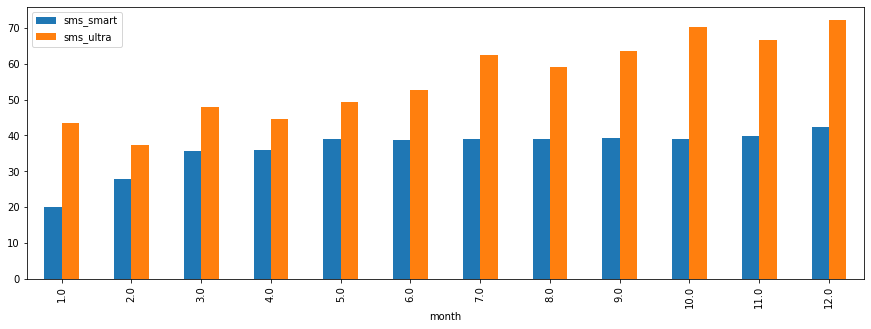

In [43]:
data_sms = data[['month', 'message', 'tariff']]
data_sms_smart = data_sms.query('tariff == "smart"')
data_sms_smart
data_sms_ultra = data_sms.query('tariff == "ultra"')
sms = pd.DataFrame({'sms_smart' : data_sms_smart['message'],
                   'sms_ultra' : data_sms_ultra['message'],
                   'month' : data_sms['month']})
sms = sms.groupby('month').mean()
sms.plot(kind='bar', figsize=(15,5))


Итак на графике мы видим, что пользователи тарифа Ультра отправляют больше смс в любой месяц, но больше всего в октябре, ноябре и декабре. Пользователи тарифа Смарт отправляют примерно одинаковое количество сообщений в среднем, но меньше всего в январе.

<AxesSubplot:xlabel='month'>

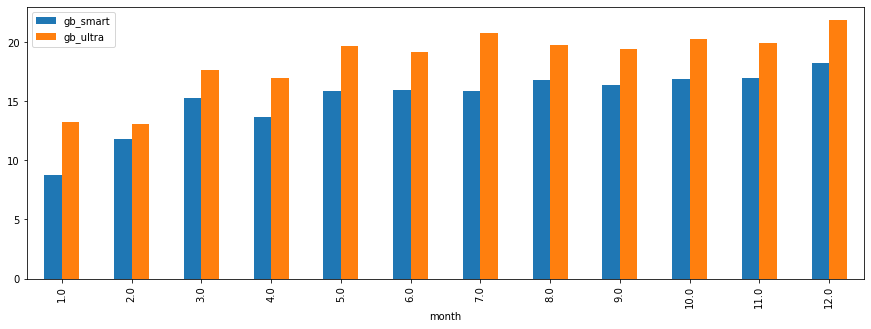

In [44]:
data_gb = data[['month', 'gb_used', 'tariff']]
data_gb_smart = data_gb.query('tariff == "smart"')
data_gb_ultra = data_gb.query('tariff == "ultra"')
gb = pd.DataFrame({'gb_smart' : data_gb_smart['gb_used'],
                   'gb_ultra' : data_gb_ultra['gb_used'],
                   'month' : data_gb['month']})
gb = gb.groupby('month').mean()
gb.plot(kind='bar', figsize=(15,5))

Аналогично графику с смс, мы построили график по использованию трафика интернета. Пользователи Ультра используют в среднем больше Гб, чем Смарт. Однако в январе и феврале количество интернета меньше в обоих тарифах.

<AxesSubplot:xlabel='month'>

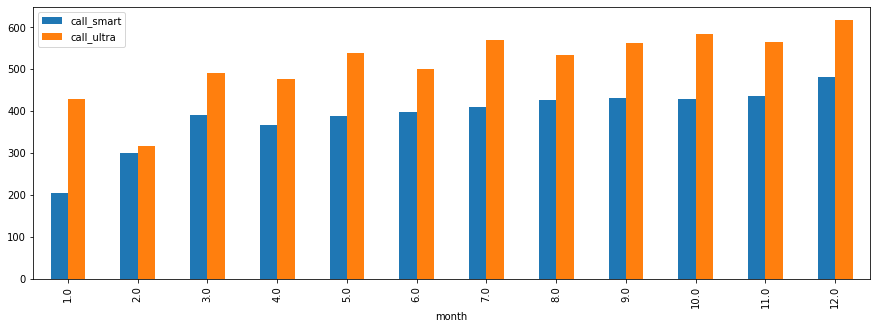

In [45]:
data_call = data[['month', 'minut', 'tariff']]
data_call_smart = data_call.query('tariff == "smart"')
data_call_ultra = data_call.query('tariff == "ultra"')
call = pd.DataFrame({'call_smart' : data_call_smart['minut'],
                   'call_ultra' : data_call_ultra['minut'],
                   'month' : data_call['month']})
call = call.groupby('month').mean()
call.plot(kind='bar', figsize=(15,5))

Звонят больше в тарифе Ультра. И январь с февралем опять проседают в двух тарифах, примерно как и во всех показателях.

In [46]:
#сгруппируем таблицу по тарифам
data_all_tariff = data.groupby('tariff').mean()
data_all_tariff

,user_id,age,month,gb_used,minut,message,tariff_pay,dop_pay,profit
tariff,,,,,,,,,
smart,1246.472858,46.550022,8.346948,16.336176,419.229073,38.736075,550.0,739.973531,1289.973531
ultra,1262.636643,46.824974,8.261538,19.694359,548.890542,61.587261,1950.0,121.136131,2071.136131


<AxesSubplot:xlabel='tariff'>

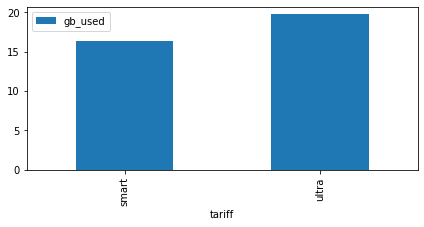

In [47]:
data_all_tariff_gb = data_all_tariff[['gb_used']]

data_all_tariff_gb.plot(kind='bar', figsize=(7,3))

На графике видим разницу средних между двумя тарифами. Ежемесячно в тарифе ультра используют больше Гб, чем в смарте

<AxesSubplot:xlabel='tariff'>

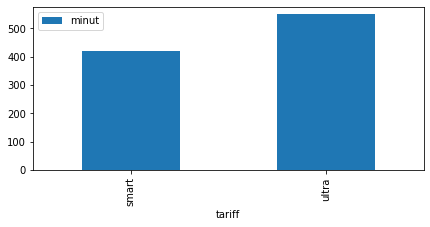

In [48]:
data_all_tariff_call = data_all_tariff[['minut']]

data_all_tariff_call.plot(kind='bar', figsize=(7,3))

<AxesSubplot:xlabel='tariff'>

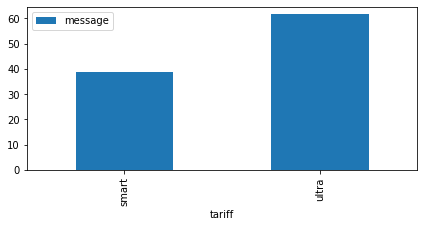

In [49]:
data_all_tariff_sms = data_all_tariff[['message']]

data_all_tariff_sms.plot(kind='bar', figsize=(7,3))

<AxesSubplot:xlabel='tariff'>

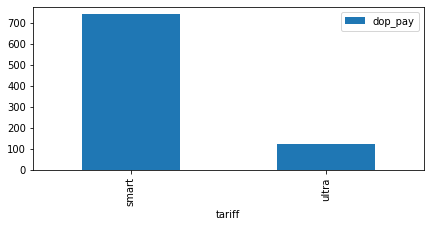

In [50]:
data_all_tariff_pay = data_all_tariff[['dop_pay']]

data_all_tariff_pay.plot(kind='bar', figsize=(7,3))

<AxesSubplot:xlabel='tariff'>

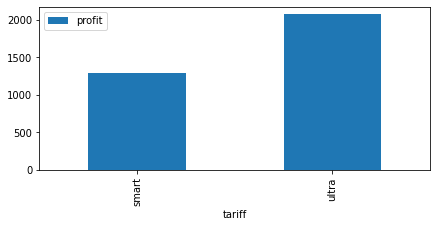

In [51]:
data_all_tariff_p = data_all_tariff[['profit']]

data_all_tariff_p.plot(kind='bar', figsize=(7,3))

И звонков и сообщений больше в тарифе ультра, если смотреть по показателю "в среднем в месяц". Пользователи тарифа Смарт доплачивают намного больше, чем Ультра, но при этом выручка компании больше с пользователей Ультра

### Стандартное отклонение и дисперсия

**Стандартное отклонение по звонкам**

In [52]:
data_call_smart['minut'].describe()

count    2222.000000
mean      419.229073
std       189.206167
min         0.000000
25%       285.000000
50%       423.000000
75%       545.750000
max      1435.000000
Name: minut, dtype: float64

In [53]:
data_call_ultra['minut'].describe()

count     941.000000
mean      548.890542
std       306.619353
min         0.000000
25%       315.000000
50%       531.000000
75%       760.000000
max      1673.000000
Name: minut, dtype: float64

В тарифе Смарт стандартное отклонение - 189, а в Ультра - 306. 


**Стандартное отклонение по смс**

In [54]:
data_sms_smart['message'].describe()

count    1921.000000
mean       38.736075
std        26.781088
min         1.000000
25%        17.000000
50%        34.000000
75%        55.000000
max       143.000000
Name: message, dtype: float64

In [55]:
data_sms_ultra['message'].describe()

count    785.000000
mean      61.587261
std       46.040193
min        1.000000
25%       24.000000
50%       51.000000
75%       88.000000
max      224.000000
Name: message, dtype: float64

С помощью метода `describe()` мы видим максимальные и минимальные числа, а так же стандартное отклонение. 

Стандартное отклонение по отправленым сообщениям в Смарте - 26, в Ультра - 46

**Стандартное отклонение в интернет трафике**

In [56]:
data_gb_smart['gb_used'].describe()

count    2228.000000
mean       16.336176
std         5.737923
min         0.000000
25%        13.000000
50%        17.000000
75%        20.000000
max        38.000000
Name: gb_used, dtype: float64

In [57]:
data_gb_ultra['gb_used'].describe()

count    975.000000
mean      19.694359
std        9.702924
min        0.000000
25%       12.000000
50%       19.000000
75%       27.000000
max       49.000000
Name: gb_used, dtype: float64

Стандартное отклонение в трафике интернета в Смарте - 14, в Ультра - 19

In [58]:
data.pivot_table(index= 'tariff', values= 'minut', aggfunc= ['mean', 'var','std'])

,mean,var,std
,minut,minut,minut
tariff,,,
smart,419.229073,35798.973616,189.206167
ultra,548.890542,94015.427368,306.619353


**Дисперсия**

С помощью метода `var()` мы найдем Дисперсию, укажем параметр ddof=1, потому что работаем с выборкой

In [59]:
data_gb_smart['gb_used'].var(ddof=1)

32.92375582354312

In [60]:
data_gb_ultra['gb_used'].var(ddof=1)

94.14673405991681

In [61]:
data_call_smart['minut'].var(ddof=1)

35798.97361633957

In [62]:
data_call_ultra['minut'].var(ddof=1)

94015.42736789743

In [63]:
data_sms_smart['message'].var(ddof=1)

717.2266614610446

In [64]:
data_sms_ultra['message'].var(ddof=1)

2119.699327310542

Дисперсия в тарифе Ультра больше, чем в Смарте во всех показателях

## Проверка гипотез

### Гипотеза 1

**Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются**

In [65]:
data_ultra = data.query('tariff == "ultra"')
data_smart = data.query('tariff == "smart"')

- Н0 - "Средняя выручка пользователей различается"
- Н1 - "Средняя выручка пользователей не различается"

In [66]:
pay_1 = data_smart['profit']
pay_2 = data_ultra['profit']
alpha=0.05
results = st.ttest_ind(pay_1,pay_2)
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Выручка различается')
else:
    print('Выручка не различается')

p-значение: 9.59472004286221e-160
Выручка различается


- Значит гипотеза: Средняя выручка в тарифах различается верно

### Гипотеза 2

**средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов**

Для начала надо выделить пользователей Москвы

In [67]:
data_moscow = data.query('city == "Москва"')
data_all_city = data.query('city != "Москва"')
data_moscow.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,gb_used,minut,message,tariff_pay,dop_pay,profit
8,1001,41.0,NaT,Москва,Иван,Ежов,2018-11-01,smart,11.0,18.0,430.0,NaN,550,600.0,1150.0
9,1001,41.0,NaT,Москва,Иван,Ежов,2018-11-01,smart,12.0,14.0,414.0,NaN,550,0.0,550.0
17,1003,23.0,NaT,Москва,Белла,Белякова,2018-08-17,ultra,8.0,9.0,380.0,37.0,1950,0.0,1950.0
18,1003,23.0,NaT,Москва,Белла,Белякова,2018-08-17,ultra,9.0,13.0,961.0,91.0,1950,0.0,1950.0
19,1003,23.0,NaT,Москва,Белла,Белякова,2018-08-17,ultra,10.0,15.0,855.0,83.0,1950,0.0,1950.0


In [68]:
data_all_city.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,gb_used,minut,message,tariff_pay,dop_pay,profit
0,1000,52.0,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5.0,3.0,159.0,22.0,1950,0.0,1950.0
1,1000,52.0,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.0,23.0,172.0,60.0,1950,0.0,1950.0
2,1000,52.0,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7.0,14.0,340.0,75.0,1950,0.0,1950.0
3,1000,52.0,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0,14.0,408.0,81.0,1950,0.0,1950.0
4,1000,52.0,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9.0,15.0,466.0,57.0,1950,0.0,1950.0


- Н0 - "Средняя выручка Москвы отличается от других городов"
- Н1 - "Средняя выручка Москвы не отличается от других городов"

In [69]:
pay_3 = data_moscow['profit']
pay_4 = data_all_city['profit']
alpha=0.05
results = st.ttest_ind(pay_3,pay_4)
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Выручка различается')
else:
    print('Выручка не различается')

p-значение: nan
Выручка не различается


Получается, что выручка не зависит от того, в каком регионе проживает пользователь

- Гипотеза Н0 отвергается, а Н1 не отвергается. 

### Перепроверка гипотез

Я люблю быть уверенной в своих утверждениях, поэтому давайте простым методом убедимся в правильности гипотез.

In [70]:
data_smart['profit'].mean()

1289.9735307312696

In [71]:
data_ultra['profit'].mean()

2071.136131013306

In [72]:
data_moscow['profit'].mean()

1546.7135842880523

In [73]:
data_all_city['profit'].mean()

1523.6258188824663

## Вывод

Простым способом поиска среднего числа по столбцу, мы нашли четыре показателя. Наглядно видно, что выручка по тарифам действительно различается, а по городам нет. 

Пользователи тарифа Ультра приносят больше денег чем в тарифе Смарт. Не смотря на небольшую стоимость тарифа Смарт, пользователи часто выходят за лимит и доплачивают, но даже эта сумма меньше платежей пользователей Ультра. Разница в ежемесячном платеже в среднем в 60%. Поэтому вывод напрашивается сам собой: выгоднее предлагать новым пользователям тариф Ультра, если судить по средней выручке.

Проведя подробное исследование проекта, можно заметить, что пользователи Ультра во всем опережают Смарт, ну кроме доплат за превышение лимитов. При стоимости тарифов в 550 и 1950 рублей, пользователи смарта доплачивают сверху в среднем еще 123%, а Ультра всего 5%. Так вот если посмотреть с этой точки зрения, то тариф Смарт выгоднее предлагать, он приносит больше доплат, намного больше.

На графиках было видно, что в январе и феврале очень проседает использование вообще всего: и звонков и смс и интернета. Я бы в период спада активно предлагала тариф Смарт для новых пользователей, он дешевле, но компанию знает, что пользователь заплатит в два раза больше в итоге. А вот в периоды ноября и декабря, когда спрос и так велик, можно продавать тарифы Ультра.